In [ ]:
'''
Alex Costanzino
MSc student in Artificial Intelligence
@ Alma Mater Studiorum, University of Bologna
July, 2021
'''

# Visual Inspection of Motorcycle Connecting Rods
by Alex Costanzino

Import of all the libraries that will be used in the project:

In [35]:
import os
import copy

import cv2
import numpy as np
import math

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

Preparation of the folder's path and the ids of the images for each task:

In [36]:
folder_path = r'C:\Users\AlexC\OneDrive\Desktop\computer-vision_project\ispezione-bielle-immagini'

task_one = ['TESI00.BMP', 'TESI01.BMP', 'TESI12.BMP', 'TESI21.BMP', 'TESI31.BMP', 'TESI33.BMP']
task_two1 = ['TESI44.BMP', 'TESI47.BMP', 'TESI48.BMP', 'TESI49.BMP']
task_two2 = ['TESI50.BMP', 'TESI51.BMP']
task_two3 = ['TESI90.BMP', 'TESI92.BMP', 'TESI98.BMP']

Creation of a routine to load all images on a dict:

In [37]:
def load_images_from_folder(folder):
    images = {}
    
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename), cv2.IMREAD_GRAYSCALE)
        
        if img is not None: # Sanity check
            images[filename] = img

    return images

In [38]:
imgs_dict = load_images_from_folder(folder_path)

## First task

Visualization of the images of the first task:

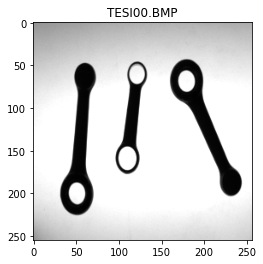

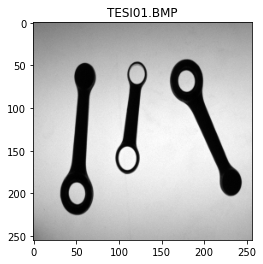

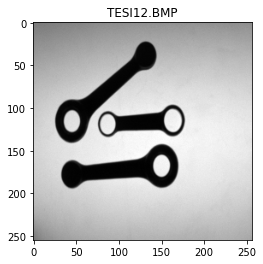

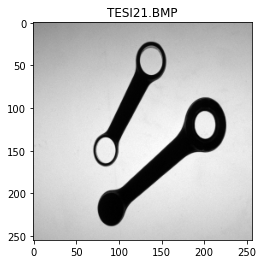

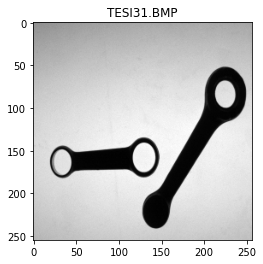

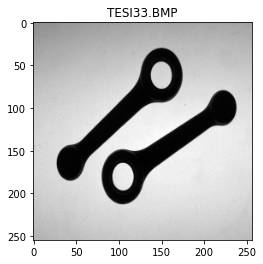

In [39]:
for key in task_one:
    plt.title(key)
    plt.imshow(imgs_dict[key], cmap = 'gray')
    plt.show()

For the first task, images contain only connecting rods that have been carefully placed to appear well separated in images, taken by the backlighting technique.
However, for flexibility reasons the system should not require any change to work properly with lighting sources of different power.
So, supposing that the stability over time of the lighting conditions can't be guaranteed an automatic threshold selection is required.

Let's inspect the histograms first:

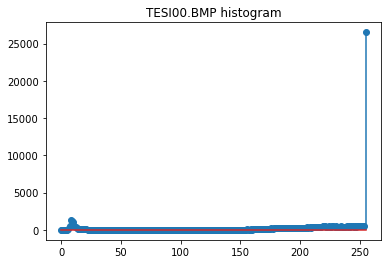

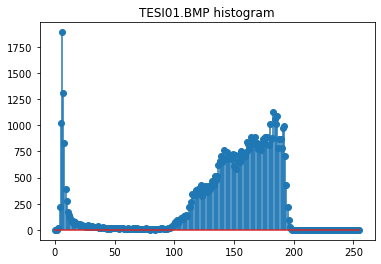

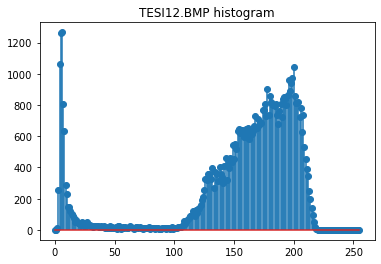

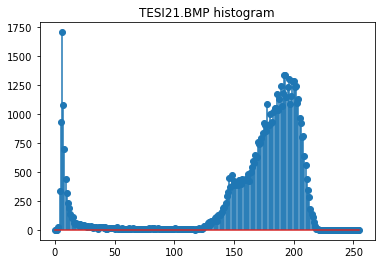

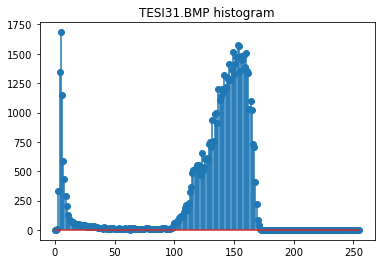

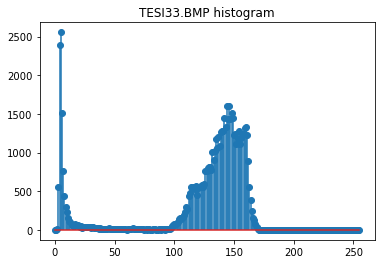

In [40]:
for key in task_one:
    hist, bins = np.histogram(imgs_dict[key].flatten(), 256, [0,256]) # (Image, number of bins, range of bins)
    
    plt.title(key + ' ' + 'histogram')
    plt.stem(hist, use_line_collection = True)
    plt.show()

Before tresholding the image an intensity transformation can be applied to enhance the contrast and provide a better binarization.

Let's try with an exponential operator:

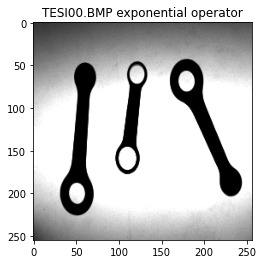

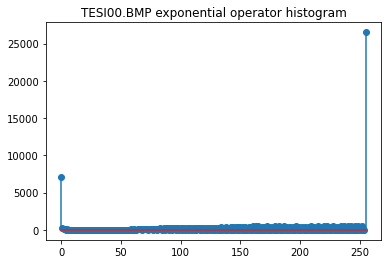

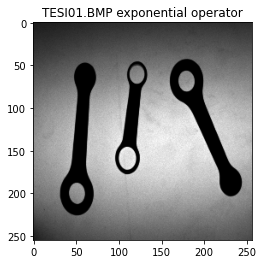

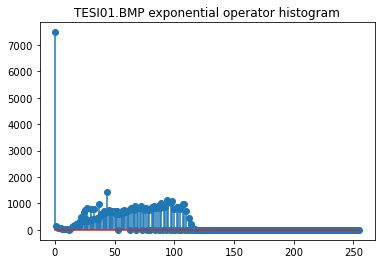

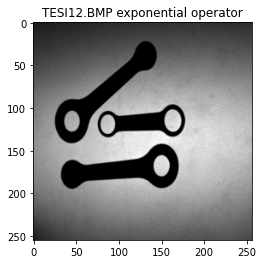

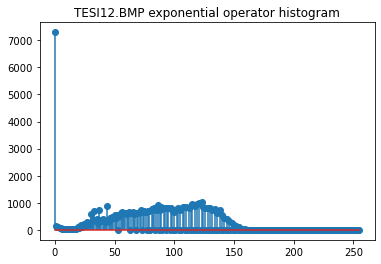

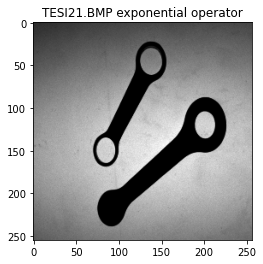

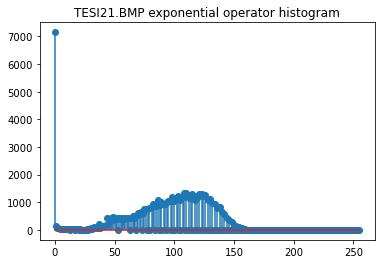

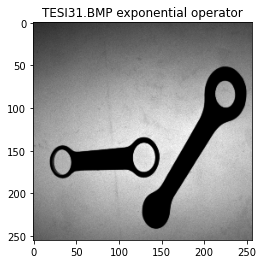

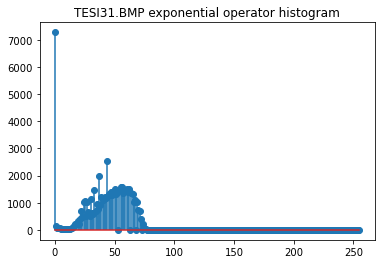

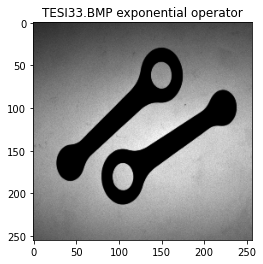

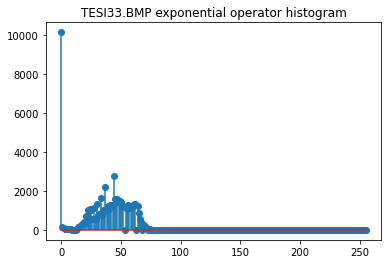

In [41]:
imgs_dict_int = copy.deepcopy(imgs_dict)
r = 3

for key in task_one:
    imgs_dict_int[key] = 255*((imgs_dict[key]/255)**r)
    hist, bins = np.histogram(imgs_dict_int[key].flatten(), 256, [0,256]) # (Image, number of bins, range of bins)
    
    plt.title(key + ' ' + 'exponential operator')
    plt.imshow(imgs_dict_int[key], cmap = 'gray')
    plt.show()
    
    plt.title(key + ' ' + 'exponential operator histogram')
    plt.stem(hist, use_line_collection = True)
    plt.show()

Since the histograms are clearly bimodal it could be possible applying a mean intensity thresholding. 
Although, not always the classes seems balanced, so a percentile may be used.

Let's define a function to find a percentile value:

In [42]:
def find_percentile_value(hist, percentile):
    s = 0
    idx = 0
    total_pixel = np.sum(hist)
    
    while(s < total_pixel*percentile/100):
        s += hist[idx]
        idx += 1
        
    return idx

In [43]:
''' To tune the percentile'''
percentiles = []
means = []
    
for key in task_one:
    hist, bins = np.histogram(imgs_dict_int[key].flatten(), 256, [0,256]) # (Image, number of bins, range of bins)
    percentiles.append(find_percentile_value(hist, 12))
    means.append(imgs_dict_int[key].mean())

print(percentiles)
print(means)

[18, 5, 7, 20, 13, 1]
[181.13681853156967, 57.40451626636814, 74.45279574150403, 84.98731692043407, 41.71832096700176, 36.976544231903645]


We apply a threhsold at the 12nd percentile:

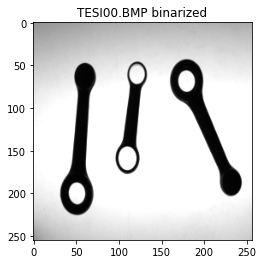

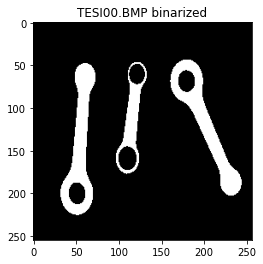

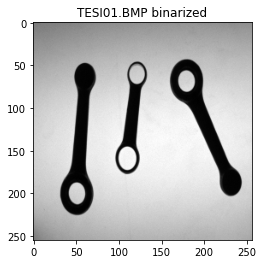

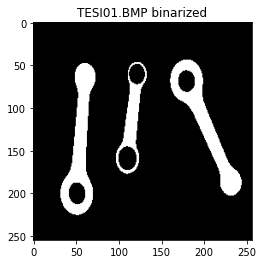

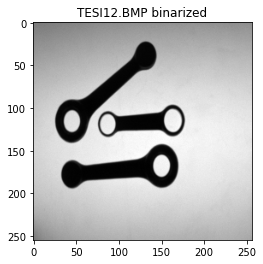

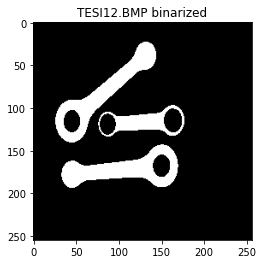

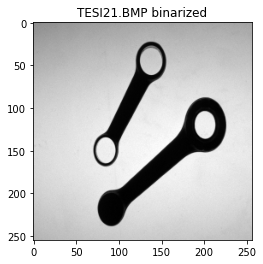

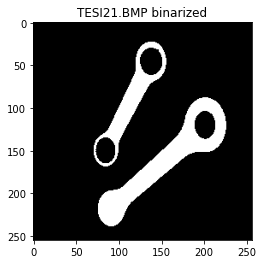

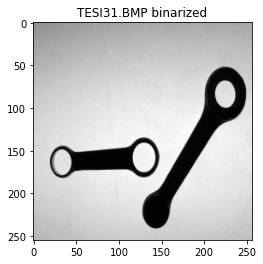

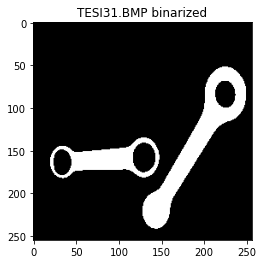

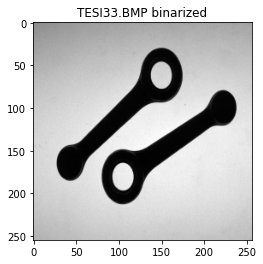

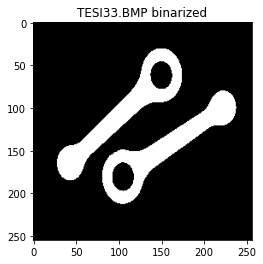

In [44]:
imgs_dict_bin = copy.deepcopy(imgs_dict_int)

for key in task_one:
    hist, bins = np.histogram(imgs_dict_int[key].flatten(), 256, [0,256])
    percentile = find_percentile_value(hist, 12)
    
    imgs_dict_bin[key][imgs_dict_int[key] <= percentile] = 1
    imgs_dict_bin[key][imgs_dict_int[key] > percentile] = 0

    # imgs_dict_bin[key] = cv2.threshold(imgs_dict_int[key], percentile, 255, cv2.THRESH_BINARY)
    
    plt.title(key + ' ' + 'binarized')
    plt.imshow(imgs_dict[key], cmap = 'gray')
    plt.show()
    
    plt.title(key + ' ' + 'binarized')
    plt.imshow(imgs_dict_bin[key], cmap = 'gray')
    plt.show()

Then, we proceed with a connected component analysis:

In [45]:
def show_blobs(num_labels, labels, stats):
    # Assign different colours in a balanced way
    label_hue = np.uint8(179 * labels / np.max(labels))
    blank_ch = 255 * np.ones_like(label_hue)
    
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)
    labeled_img[label_hue == 0] = 0
    
    for i in range(0, num_labels):
        cv2.rectangle(labeled_img, # Image
                      (stats[i][0], stats[i][1]), # Starting point
                      (stats[i][0] + stats[i][2], stats[i][1] + stats[i][3]), # Endinf point
                      (255, 0, 0), # Colour
                      1) # Thichness
    
    plt.title(key + ' ' + 'blobs')
    plt.imshow(labeled_img)
    plt.show()
    
    if key == 'TESI12.BMP':
        cv2.imwrite('\OneDrive\Desktop\computer-vision_project\lab.png', labeled_img)

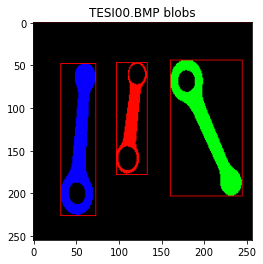

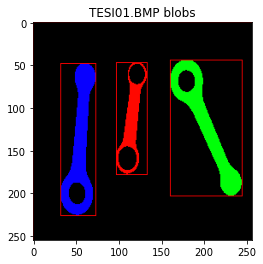

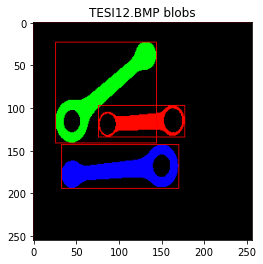

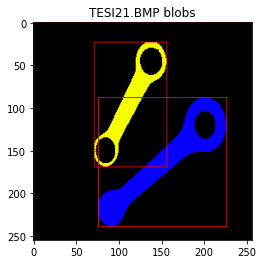

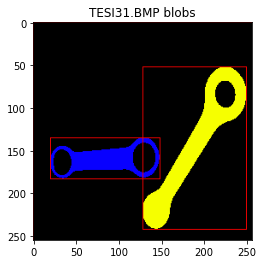

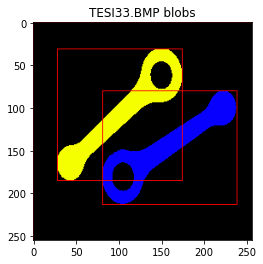

In [46]:
stat_dict = {}

for key in task_one:
    stat_dict[key] = cv2.connectedComponentsWithStats(np.uint8(imgs_dict_bin[key]), connectivity = 4)
    num_labels, labels, stats, centroids = stat_dict[key]
    
    show_blobs(num_labels, labels, stats)

Now that the components are told apart and labelled we can proceed with the analysis:
1. Type of rod (A or B);
2. Position and orientation modulo $\pi$;
3. Length $L$, width $W$, width at the barycenter $W_b$;
4. For each hole, position of the centre and diameter size.

In [47]:
def get_blob(labels, label):
    mask = np.zeros_like(labels, dtype=np.uint8)
    mask[labels == label] = 255
    return mask

In [48]:
def distances(vertexes):
    dists = []
    
    for i in range(0, len(vertexes)-2):
        dists.append(np.linalg.norm(vertexes[i] - vertexes[i+1]))
    
    return dists

In [49]:
def get_barycenter_width(component, angle, centroid, contours):
    # Calculate alpha and beta
    alpha = -math.sin(angle)
    beta = math.cos(angle)

    # Get major and minor axis
    major = (alpha, -beta, beta * centroid[1] - alpha * centroid[0])
    minor = (beta, alpha, -beta * centroid[0] - alpha * centroid[1])

    # Points at barycenter width (to be detected)
    wb_1 = wb_2 = (0, 0)
    min_wb_1 = min_wb_2 = float("inf")

    # Iterate over contour points only (since points at barycenter width belong to them)
    for p in contours[0]:
        x = p[0][0]
        y = p[0][1]

        # Calculate signed distances between major and minor axis
        dist_maj = (major[0] * x + major[1] * y + major[2]) / math.sqrt(major[0] ** 2 + major[1] ** 2)
        dist_min = (minor[0] * x + minor[1] * y + minor[2]) / math.sqrt(minor[0] ** 2 + minor[1] ** 2)

        # If the absolute distance from the minor axis is less than the minimum ever encountered
        # for wb_1 AND the distance from the major axis is positive
        if abs(dist_min) <= min_wb_1 and dist_maj > 0:
            wb_1 = (x, y)
            min_wb_1 = abs(dist_min)

        # If the absolute distance from the minor axis is less than the minimum ever encountered
        # for wb_2 AND the distance from the major axis is negative
        if abs(dist_min) <= min_wb_2 and dist_maj < 0:
            wb_2 = (x, y)
            min_wb_2 = abs(dist_min)

    # Calculate width as euclidean distance
    width = math.sqrt((wb_1[0] - wb_2[0]) ** 2 + (wb_1[1] - wb_2[1]) ** 2)
    
    return width

The image TESI00.BMP has 3 rods:


Rod 1 is of type A, so it has one hole.
The hole is positioned at (179.04244995117188, 68.61289978027344) and it has a diameter of 23.2347.
The rod 1 is positioned at (195.38079833984375, 104.830078125) with an angle of 156.6454
The rod 1 has lenght 168.6563 and width 39.5362.
The rod 1 has a width at barycenter of 21.0238.


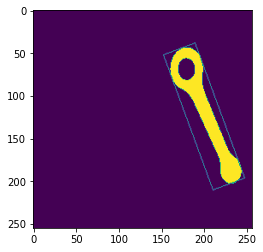

Rod 2 is of type B, so it has two holes.
The first hole is positioned at (109.95199584960938, 158.90113830566406) and it has a diameter of 25.2817.
The second hole is positioned at (121.06291198730469, 60.327850341796875) and it has a diameter of 25.2817.
The rod 2 is positioned at (114.98714447021484, 117.5515365600586) with an angle of 6.3003
The rod 2 has lenght 130.9147 and width 26.8891.
The rod 2 has a width at barycenter of 123.0163.


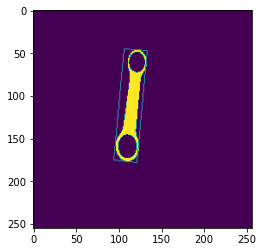

Rod 3 is of type A, so it has one hole.
The hole is positioned at (51.069236755371094, 199.7719268798828) and it has a diameter of 23.1799.
The rod 3 is positioned at (54.980709075927734, 146.01522827148438) with an angle of 4.0422
The rod 3 has lenght 177.2407 and width 37.2521.
The rod 3 has a width at barycenter of 13.1529.


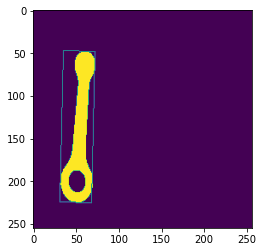

--------------------------------------------------------------------------------------------------------------
The image TESI01.BMP has 3 rods:


Rod 1 is of type A, so it has one hole.
The hole is positioned at (179.04244995117188, 68.61289978027344) and it has a diameter of 23.2347.
The rod 1 is positioned at (195.4996337890625, 105.72748565673828) with an angle of 157.0688
The rod 1 has lenght 168.6563 and width 39.5362.
The rod 1 has a width at barycenter of 65.0077.


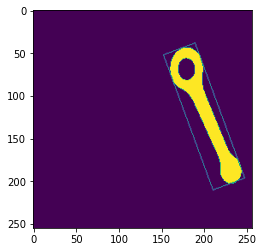

Rod 2 is of type B, so it has two holes.
The first hole is positioned at (109.8963623046875, 158.85226440429688) and it has a diameter of 25.3069.
The second hole is positioned at (121.0465087890625, 60.32598114013672) and it has a diameter of 25.3069.
The rod 2 is positioned at (115.01094055175781, 117.08931732177734) with an angle of 6.2636
The rod 2 has lenght 130.9147 and width 26.8891.
The rod 2 has a width at barycenter of 127.0157.


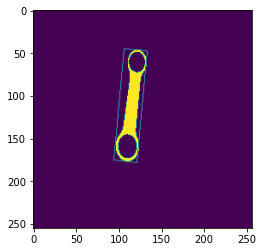

Rod 3 is of type A, so it has one hole.
The hole is positioned at (51.069236755371094, 199.7719268798828) and it has a diameter of 23.1799.
The rod 3 is positioned at (54.86172866821289, 147.09938049316406) with an angle of 4.1608
The rod 3 has lenght 177.2407 and width 37.2521.
The rod 3 has a width at barycenter of 13.1529.


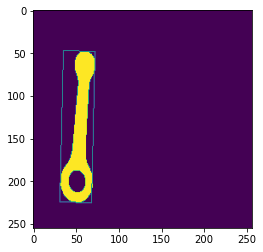

--------------------------------------------------------------------------------------------------------------
The image TESI12.BMP has 3 rods:


Rod 1 is of type A, so it has one hole.
The hole is positioned at (44.997352600097656, 115.50765991210938) and it has a diameter of 23.3168.
The rod 1 is positioned at (80.65398406982422, 83.88113403320312) with an angle of 47.9329
The rod 1 has lenght 152.0466 and width 43.7970.
The rod 1 has a width at barycenter of 17.2047.


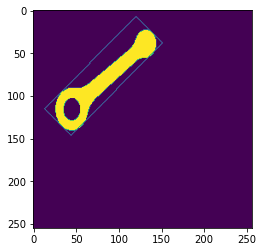

Rod 2 is of type B, so it has two holes.
The first hole is positioned at (86.8736572265625, 119.02727508544922) and it has a diameter of 22.3692.
The second hole is positioned at (163.21148681640625, 114.6301040649414) and it has a diameter of 22.3692.
The rod 2 is positioned at (128.93695068359375, 116.88624572753906) with an angle of 86.4116
The rod 2 has lenght 100.1229 and width 35.0628.
The rod 2 has a width at barycenter of 100.0200.


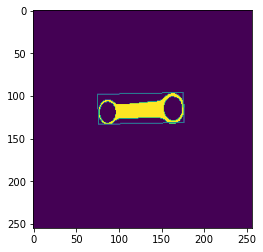

Rod 3 is of type A, so it has one hole.
The hole is positioned at (149.8824005126953, 167.6458282470703) and it has a diameter of 23.8166.
The rod 3 is positioned at (107.22466278076172, 172.1576385498047) with an angle of 84.2641
The rod 3 has lenght 136.1249 and width 49.0539.
The rod 3 has a width at barycenter of 23.8537.


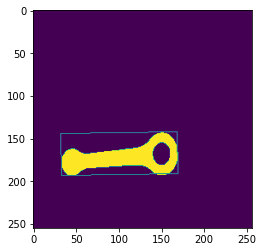

--------------------------------------------------------------------------------------------------------------
The image TESI21.BMP has 2 rods:


Rod 1 is of type B, so it has two holes.
The first hole is positioned at (84.4615249633789, 149.62725830078125) and it has a diameter of 27.2568.
The second hole is positioned at (137.7851104736328, 45.388492584228516) and it has a diameter of 27.2568.
The rod 1 is positioned at (120.27233123779297, 79.65257263183594) with an angle of 26.2872
The rod 1 has lenght 156.7431 and width 37.8462.
The rod 1 has a width at barycenter of 19.6977.


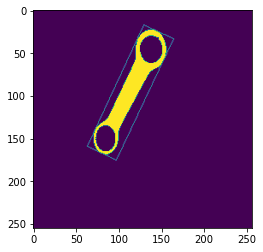

Rod 2 is of type A, so it has one hole.
The hole is positioned at (200.62112426757812, 119.78802490234375) and it has a diameter of 29.0434.
The rod 2 is positioned at (156.381591796875, 158.6039581298828) with an angle of 48.1163
The rod 2 has lenght 193.1324 and width 56.4717.
The rod 2 has a width at barycenter of 22.6274.


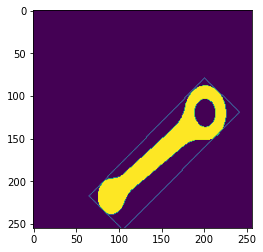

--------------------------------------------------------------------------------------------------------------
The image TESI31.BMP has 2 rods:


Rod 1 is of type A, so it has one hole.
The hole is positioned at (224.3050537109375, 83.86434173583984) and it has a diameter of 28.2884.
The rod 1 is positioned at (196.24703979492188, 131.82965087890625) with an angle of 29.9668
The rod 1 has lenght 208.8494 and width 52.1468.
The rod 1 has a width at barycenter of 26.1725.


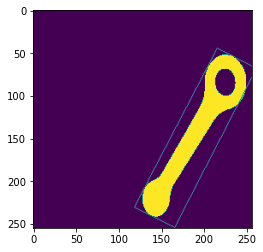

Rod 2 is of type B, so it has two holes.
The first hole is positioned at (33.669921875, 163.58383178710938) and it has a diameter of 26.1726.
The second hole is positioned at (129.32936096191406, 157.93910217285156) and it has a diameter of 26.1726.
The rod 2 is positioned at (86.57819366455078, 161.2664031982422) with an angle of 85.9565
The rod 2 has lenght 127.1285 and width 46.0496.
The rod 2 has a width at barycenter of 58.1378.


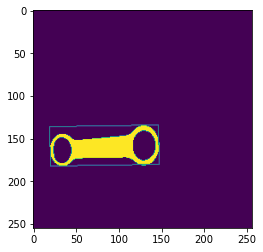

--------------------------------------------------------------------------------------------------------------
The image TESI33.BMP has 2 rods:


Rod 1 is of type A, so it has one hole.
The hole is positioned at (149.53485107421875, 61.76917266845703) and it has a diameter of 29.6079.
The rod 1 is positioned at (103.24641418457031, 105.69467163085938) with an angle of 45.6148
The rod 1 has lenght 194.2148 and width 55.2528.
The rod 1 has a width at barycenter of 32.5576.


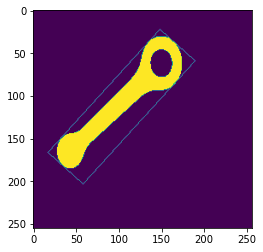

Rod 2 is of type A, so it has one hole.
The hole is positioned at (104.68775939941406, 180.4769744873047) and it has a diameter of 29.9180.
The rod 2 is positioned at (144.9427490234375, 152.55886840820312) with an angle of 55.5148
The rod 2 has lenght 186.4685 and width 57.4348.
The rod 2 has a width at barycenter of 179.9028.


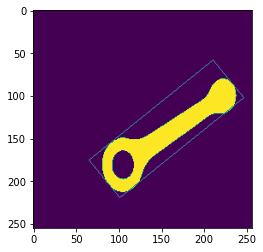

--------------------------------------------------------------------------------------------------------------


In [50]:
for key in task_one:
    print('The image {} has {} rods:'.format(key, stat_dict[key][0] - 1))
    print('\n')
    
    for i in range(1, stat_dict[key][0]): # Start from 1 since the first is the background (No of connect comp.)
        mask = get_blob(stat_dict[key][1], i) # Get all the blobs of the image at the time
        contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) # Get the contours of the blob
        
        # Check the type of the rod based on the number of contours found on the mask
        if len(contours) == 2:
            print('Rod {} is of type A, so it has one hole.'.format(i))
            
            (x,y), (_,_), angle = cv2.fitEllipse(contours[1])
            area = cv2.contourArea(contours[1])
            equi_diameter = np.sqrt(4*area/np.pi)
            print('The hole is positioned at {} and it has a diameter of {:.4f}.'.format((x,y), equi_diameter))
            
        elif len(contours) == 3:
            print('Rod {} is of type B, so it has two holes.'.format(i))
            
            (x,y), (_,_), angle = cv2.fitEllipse(contours[1])
            area = cv2.contourArea(contours[1])
            equi_diameter = np.sqrt(4*area/np.pi)
            print('The first hole is positioned at {} and it has a diameter of {:.4f}.'.format((x,y), equi_diameter))
            
            (x,y), (_,_), angle = cv2.fitEllipse(contours[2])
            area = cv2.contourArea(contours[1])
            equi_diameter = np.sqrt(4*area/np.pi)
            print('The second hole is positioned at {} and it has a diameter of {:.4f}.'.format((x,y), equi_diameter))
        
        # Orientation calculation
        (x,y), (_,_), angle = cv2.fitEllipse(contours[0])
        print('The rod {:} is positioned at {} with an angle of {:.4f}'. format(i, ((x,y)), angle))
        
        # MER calculation
        MER = cv2.minAreaRect(contours[0])
        # Extraction of the vertexes of the MER
        vertexes = cv2.boxPoints(MER)
        
        # Calculation of width and lenght
        L = max(distances(vertexes))
        W = min(distances(vertexes))
        print('The rod {:} has lenght {:.4f} and width {:.4f}.'. format(i, L, W))
        
        W_b = get_barycenter_width(mask, angle, (x,y), contours)
        print('The rod {:} has a width at barycenter of {:.4f}.'. format(i, W_b))
        
        # MER representation
        pts = np.array(vertexes, np.int32)
        pts = pts.reshape((-1,1,2))
        cv2.polylines(mask, [pts], True, (125,125,125))
        
        
        plt.imshow(mask)
        plt.show()
        
        
    print('-'*110)    

## Second task

### Part 1
The initial steps are the same of the previous task:

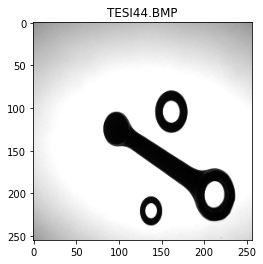

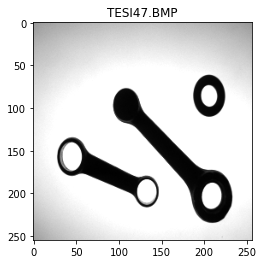

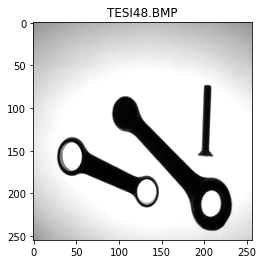

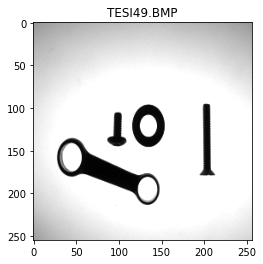

In [51]:
for key in task_two1:
    plt.title(key)
    plt.imshow(imgs_dict[key], cmap = 'gray')
    plt.show()

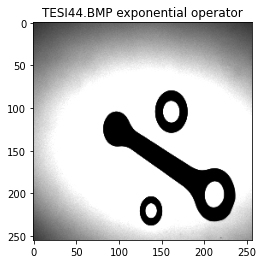

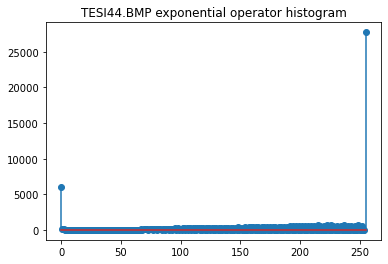

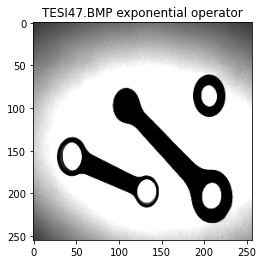

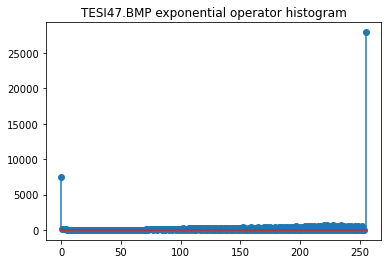

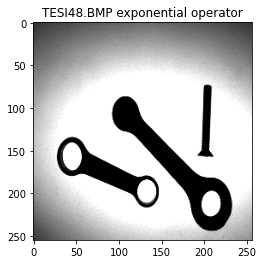

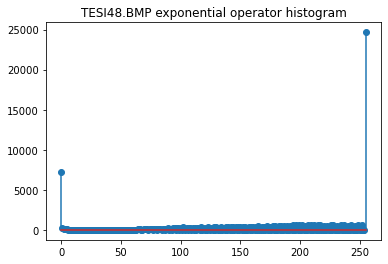

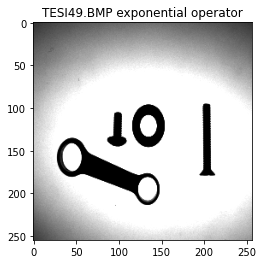

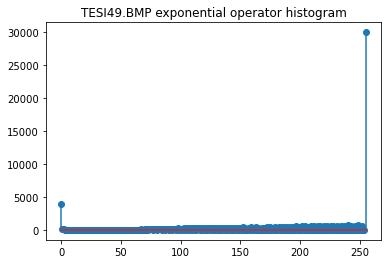

In [52]:
r = 3

for key in task_two1:
    imgs_dict_int[key] = 255*((imgs_dict[key]/255)**r)
    hist, bins = np.histogram(imgs_dict_int[key].flatten(), 256, [0,256]) # (Image, number of bins, range of bins)
    
    plt.title(key + ' ' + 'exponential operator')
    plt.imshow(imgs_dict_int[key], cmap = 'gray')
    plt.show()
    
    plt.title(key + ' ' + 'exponential operator histogram')
    plt.stem(hist, use_line_collection = True)
    plt.show()

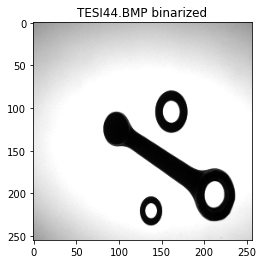

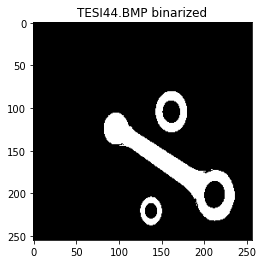

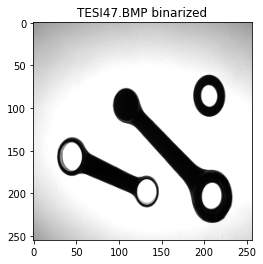

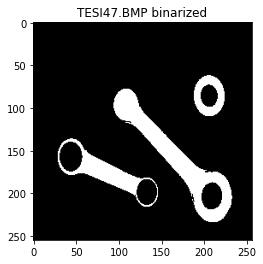

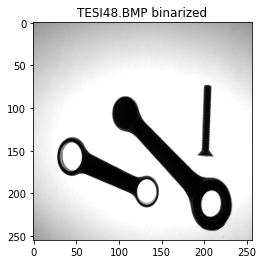

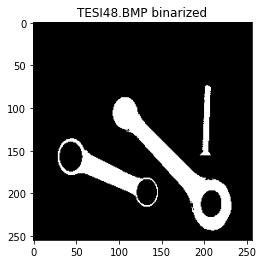

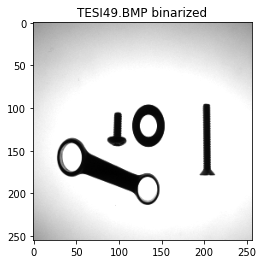

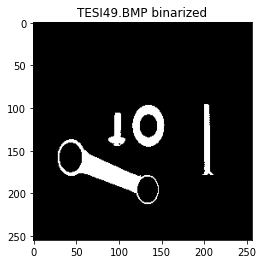

In [53]:
for key in task_two1:
    hist, bins = np.histogram(imgs_dict_int[key].flatten(), 256, [0,256])
    percentile = find_percentile_value(hist, 5)
    
    imgs_dict_bin[key][imgs_dict_int[key] <= percentile] = 1
    imgs_dict_bin[key][imgs_dict_int[key] > percentile] = 0
    
    plt.title(key + ' ' + 'binarized')
    plt.imshow(imgs_dict[key], cmap = 'gray')
    plt.show()
    
    plt.title(key + ' ' + 'binarized')
    plt.imshow(imgs_dict_bin[key], cmap = 'gray')
    plt.show()

Since after the binarization there are some broken parts it can be useful to apply a dilation to avoid spurious contours:

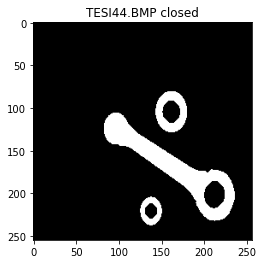

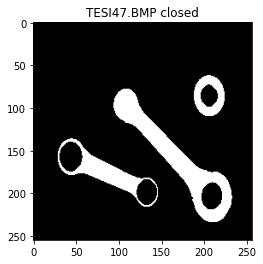

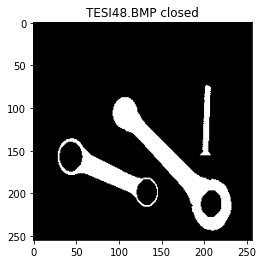

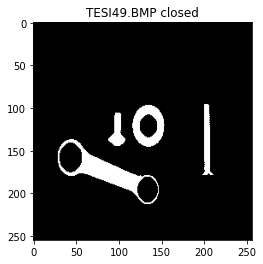

In [54]:
imgs_dict_dil = copy.deepcopy(imgs_dict_bin)
#struct = np.ones((10,10), np.uint8)

struct = np.array([[0,1,0],
                   [1,1,1],
                   [0,1,0]], np.uint8)

for key in task_two1:
    '''
    imgs_dict_dil[key] = cv2.dilate(imgs_dict_bin[key] , struct, iterations = 2)
    imgs_dict_dil[key] = cv2.erode(imgs_dict_dil[key] , struct, iterations = 1)
    '''
    imgs_dict_dil[key] = cv2.morphologyEx(imgs_dict_bin[key], cv2.MORPH_CLOSE, struct, iterations = 5)
    
    plt.title(key + ' ' + 'closed')
    plt.imshow(imgs_dict_dil[key], cmap = 'gray')
    plt.show()    

In this case we have to ignore the components that are not rods:

In [55]:
def filter_by_area(num_labels, labels, stats, centroids, area_threshold):
    total_labels = num_labels
    to_remove = []
    for i in range(1, total_labels):
        area = stats[i][cv2.CC_STAT_AREA]
        if area < area_threshold:
            to_remove.append(i)
            labels[labels == i] = 0
            num_labels -= 1

    shift_labels = list(to_remove) 
    new_labels = labels.copy()
    while shift_labels:
        i = shift_labels[0]
        if i >= total_labels:
            break
        shift_labels[0] = i + 1
        new_labels[new_labels == i + 1] = i
    return (
        num_labels,
        new_labels,
        np.delete(stats, to_remove, axis=0),
        np.delete(centroids, to_remove, axis=0)
    )

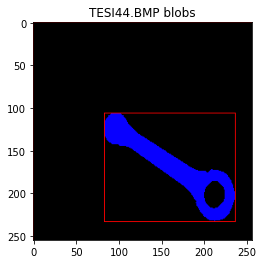

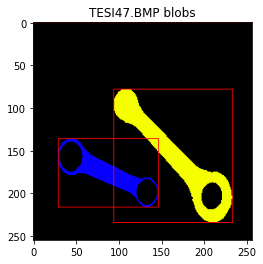

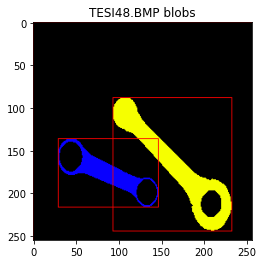

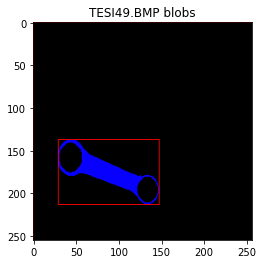

In [56]:
AREA_THRESHOLD = 1400

for key in task_two1:
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(np.uint8(imgs_dict_dil[key]), 
                                                                            connectivity = 4)
    
    num_labels, labels, stats, centroids = filter_by_area(num_labels, labels, stats, centroids, AREA_THRESHOLD)
    
    stat_dict[key] = num_labels, labels, stats, centroids
    
    show_blobs(num_labels, labels, stats)

The image TESI44.BMP has 1 rods:


Rod 1 is of type A, so it has one hole.
The hole is positioned at (211.7259979248047, 201.23594665527344) and it has a diameter of 28.2320.
The rod 1 is positioned at (172.5206298828125, 175.47720336914062) with an angle of 124.4307
The rod 1 has lenght 181.2994 and width 54.7748.
The rod 1 has a width at barycenter of 27.5136.


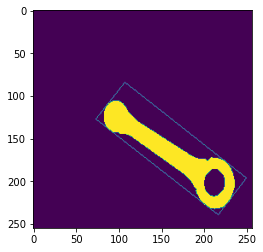

--------------------------------------------------------------------------------------------------------------
The image TESI47.BMP has 2 rods:


Rod 1 is of type A, so it has one hole.
The hole is positioned at (208.5537872314453, 203.03076171875) and it has a diameter of 28.5013.
The rod 1 is positioned at (167.78012084960938, 157.56356811523438) with an angle of 137.8015
The rod 1 has lenght 191.8016 and width 51.4305.
The rod 1 has a width at barycenter of 36.6742.


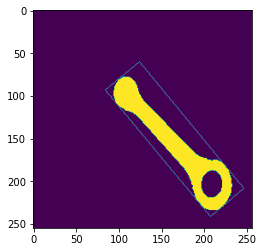

Rod 2 is of type B, so it has two holes.
The first hole is positioned at (132.63699340820312, 198.20114135742188) and it has a diameter of 27.5241.
The second hole is positioned at (43.811004638671875, 156.8706817626953) and it has a diameter of 27.5241.
The rod 2 is positioned at (71.42250061035156, 169.6256103515625) with an angle of 115.3336
The rod 2 has lenght 128.5228 and width 40.5851.
The rod 2 has a width at barycenter of 23.4307.


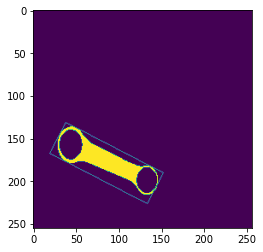

--------------------------------------------------------------------------------------------------------------
The image TESI48.BMP has 2 rods:


Rod 1 is of type A, so it has one hole.
The hole is positioned at (207.94332885742188, 212.050048828125) and it has a diameter of 28.1869.
The rod 1 is positioned at (166.22476196289062, 167.1143341064453) with an angle of 137.8607
The rod 1 has lenght 191.4225 and width 51.8292.
The rod 1 has a width at barycenter of 26.9072.


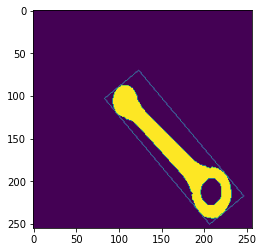

Rod 2 is of type B, so it has two holes.
The first hole is positioned at (132.55043029785156, 198.3764190673828) and it has a diameter of 27.5010.
The second hole is positioned at (43.811004638671875, 156.8706817626953) and it has a diameter of 27.5010.
The rod 2 is positioned at (71.10973358154297, 169.59938049316406) with an angle of 115.2330
The rod 2 has lenght 128.5228 and width 40.5851.
The rod 2 has a width at barycenter of 25.5539.


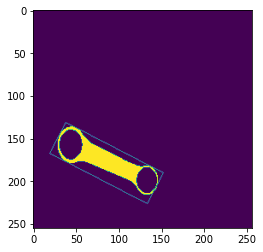

--------------------------------------------------------------------------------------------------------------
The image TESI49.BMP has 1 rods:


Rod 1 is of type B, so it has two holes.
The first hole is positioned at (133.5, 195.5) and it has a diameter of 27.5703.
The second hole is positioned at (43.63959503173828, 157.8836669921875) and it has a diameter of 27.5703.
The rod 1 is positioned at (69.00638580322266, 168.3251953125) with an angle of 112.9906
The rod 1 has lenght 127.7989 and width 40.9196.
The rod 1 has a width at barycenter of 22.0907.


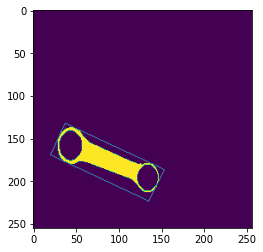

--------------------------------------------------------------------------------------------------------------


In [57]:
for key in task_two1:
    print('The image {} has {} rods:'.format(key, stat_dict[key][0] - 1))
    print('\n')
    
    for i in range(1, stat_dict[key][0]): # Start from 1 since the first is the background
        mask = get_blob(stat_dict[key][1], i) # Get all the blobs of the image at the time
        
        ##### ----- BUG WORKAROUND ----- #####
        if np.max(mask) == 0:
            mask = get_blob(stat_dict[key][1], i+2)
        ##### ----- BUG WORKAROUND ----- #####
            
        contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) # Get the contours of the blob
    
        # Check the type of the rod based on the number of contours found on the mask
        if len(contours) == 2:
            print('Rod {} is of type A, so it has one hole.'.format(i))
            
            (x,y), (_,_), angle = cv2.fitEllipse(contours[1])
            area = cv2.contourArea(contours[1])
            equi_diameter = np.sqrt(4*area/np.pi)
            print('The hole is positioned at {} and it has a diameter of {:.4f}.'.format((x,y), equi_diameter))
            
        elif len(contours) == 3:
            print('Rod {} is of type B, so it has two holes.'.format(i))
            
            (x,y), (_,_), angle = cv2.fitEllipse(contours[1])
            area = cv2.contourArea(contours[1])
            equi_diameter = np.sqrt(4*area/np.pi)
            print('The first hole is positioned at {} and it has a diameter of {:.4f}.'.format((x,y), equi_diameter))
            
            (x,y), (_,_), angle = cv2.fitEllipse(contours[2])
            area = cv2.contourArea(contours[1])
            equi_diameter = np.sqrt(4*area/np.pi)
            print('The second hole is positioned at {} and it has a diameter of {:.4f}.'.format((x,y), equi_diameter))
        
        # Orientation calculation
        (x,y), (_,_), angle = cv2.fitEllipse(contours[0])
        print('The rod {:} is positioned at {} with an angle of {:.4f}'. format(i, ((x,y)), angle))
        
        # MER calculation
        MER = cv2.minAreaRect(contours[0])
        # Extraction of the vertexes of the MER
        vertexes = cv2.boxPoints(MER)
        
        # Calculation of width and lenght
        L = max(distances(vertexes))
        W = min(distances(vertexes))
        print('The rod {:} has lenght {:.4f} and width {:.4f}.'. format(i, L, W))
        
        W_b = get_barycenter_width(mask, angle, (x,y), contours)
        print('The rod {:} has a width at barycenter of {:.4f}.'. format(i, W_b))
        
        # MER representation
        pts = np.array(vertexes, np.int32)
        pts = pts.reshape((-1,1,2))
        cv2.polylines(mask, [pts], True, (125,125,125))
    

        plt.imshow(mask)
        plt.show()
        
        
    print('-'*110)    

### Part 2


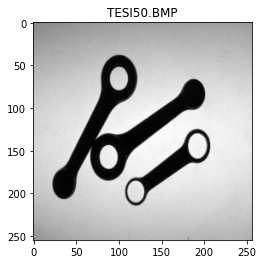

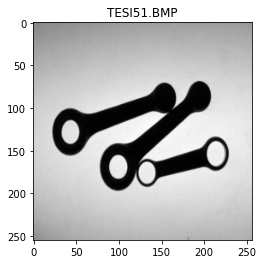

In [58]:
for key in task_two2:
    plt.title(key)
    plt.imshow(imgs_dict[key], cmap = 'gray')
    plt.show()

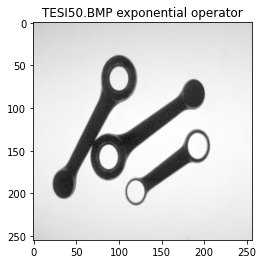

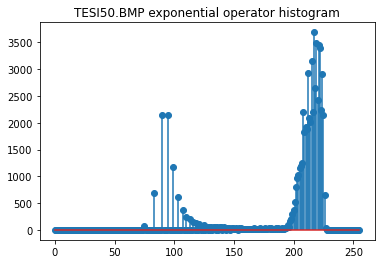

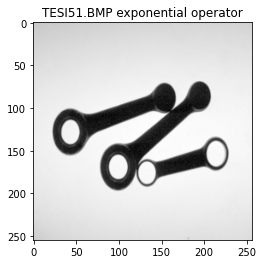

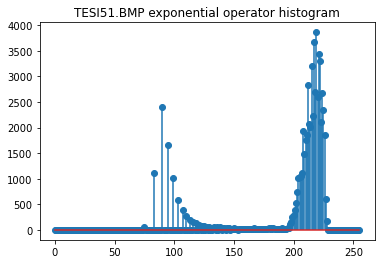

In [59]:
r = 0.25

for key in task_two2:
    imgs_dict_int[key] = 255*((imgs_dict[key]/255)**r)
    hist, bins = np.histogram(imgs_dict_int[key].flatten(), 256, [0,256]) # (Image, number of bins, range of bins)
    
    plt.title(key + ' ' + 'exponential operator')
    plt.imshow(imgs_dict_int[key], cmap = 'gray')
    plt.show()
    
    plt.title(key + ' ' + 'exponential operator histogram')
    plt.stem(hist, use_line_collection = True)
    plt.show()

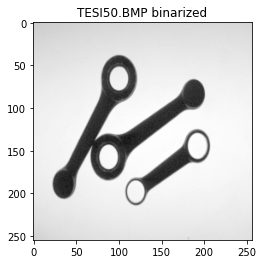

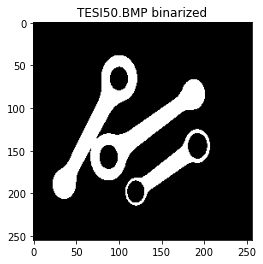

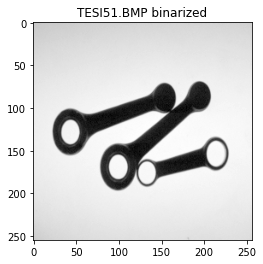

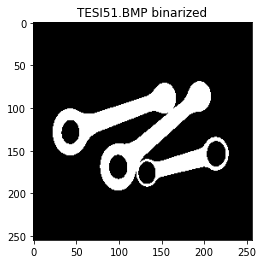

In [60]:
for key in task_two2:
    '''
    hist, bins = np.histogram(imgs_dict_int[key].flatten(), 256, [0,256])
    percentile = find_percentile_value(hist, 5)
    
    imgs_dict_bin[key][imgs_dict_med[key] <= percentile] = 1
    imgs_dict_bin[key][imgs_dict_med[key] > percentile] = 0
    '''
    _, imgs_dict_bin[key] = cv2.threshold(imgs_dict_med[key], 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    imgs_dict_bin[key] = cv2.bitwise_not(imgs_dict_bin[key])
    
    plt.title(key + ' ' + 'binarized')
    plt.imshow(imgs_dict_int[key], cmap = 'gray')
    plt.show()
    
    plt.title(key + ' ' + 'binarized')
    plt.imshow(imgs_dict_bin[key], cmap = 'gray')
    plt.show()

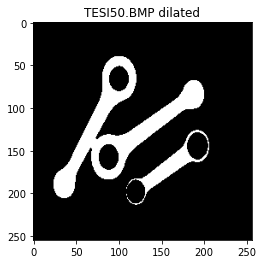

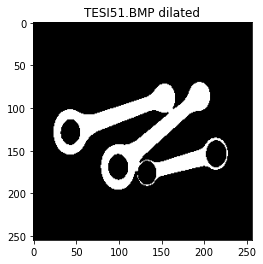

In [61]:
#imgs_dict_dil = copy.deepcopy(imgs_dict_bin)
struct1 = np.ones((2,2), np.uint8)

struct2 = np.array([[0,1,0],
                    [1,1,1],
                    [0,1,0]], np.uint8)

ker = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))


for key in task_two2:
    imgs_dict_dil[key] = cv2.erode(imgs_dict_bin[key], struct2, iterations = 1)
   
    plt.title(key + ' ' + 'dilated')
    plt.imshow(imgs_dict_dil[key], cmap = 'gray')
    plt.show()    

### Part 3

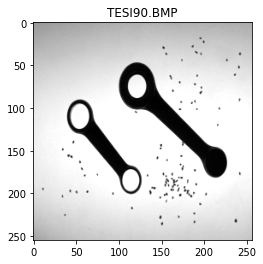

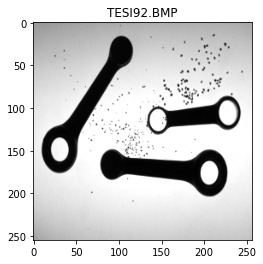

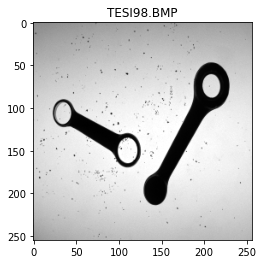

In [71]:
for key in task_two3:
    plt.title(key)
    plt.imshow(imgs_dict[key], cmap = 'gray')
    plt.show()

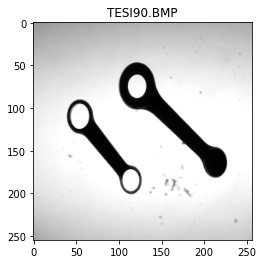

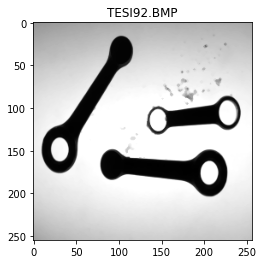

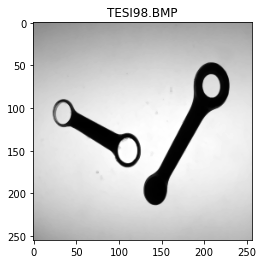

In [72]:
imgs_dict_med =  copy.deepcopy(imgs_dict)

for key in task_two3:
    imgs_dict_med[key] = cv2.medianBlur(imgs_dict[key], 3)
    imgs_dict_med[key] = cv2.medianBlur(imgs_dict_med[key], 3)
    imgs_dict_med[key] = cv2.medianBlur(imgs_dict_med[key], 3)
    
    plt.title(key)
    plt.imshow(imgs_dict_med[key], cmap = 'gray')
    plt.show()

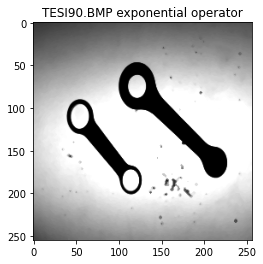

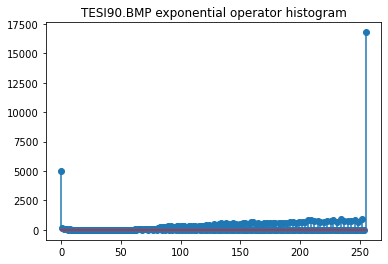

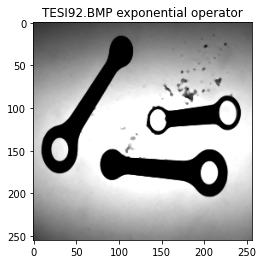

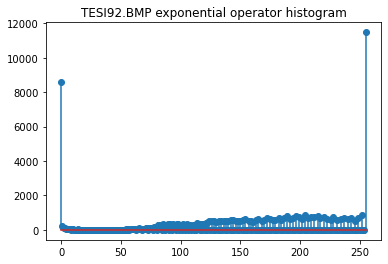

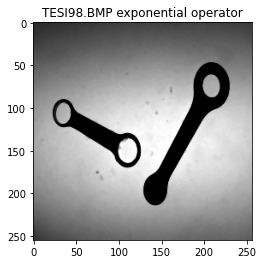

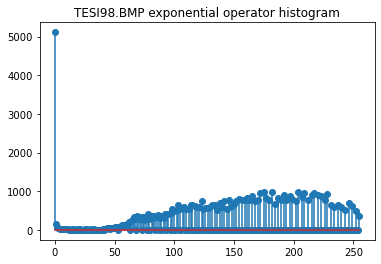

In [73]:
r = 3

for key in task_two3:
    imgs_dict_int[key] = 255*((imgs_dict_med[key]/255)**r)
    hist, bins = np.histogram(imgs_dict_int[key].flatten(), 256, [0,256]) # (Image, number of bins, range of bins)
    
    plt.title(key + ' ' + 'exponential operator')
    plt.imshow(imgs_dict_int[key], cmap = 'gray')
    plt.show()
    
    plt.title(key + ' ' + 'exponential operator histogram')
    plt.stem(hist, use_line_collection = True)
    plt.show()

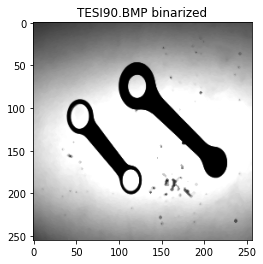

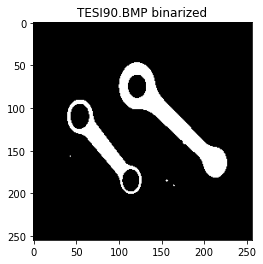

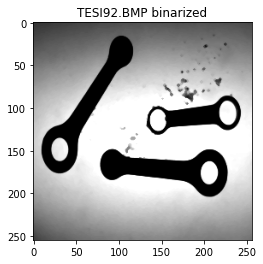

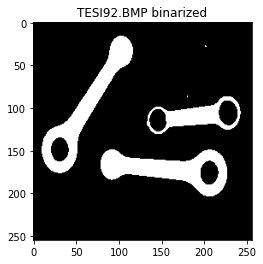

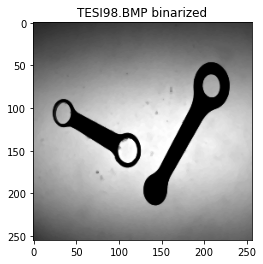

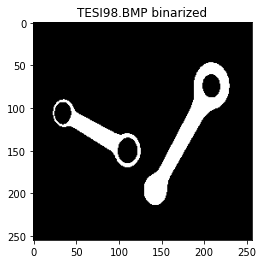

In [74]:
for key in task_two3:
    hist, bins = np.histogram(imgs_dict_int[key].flatten(), 256, [0,256])
    percentile = find_percentile_value(hist, 30)
    
    imgs_dict_bin[key][imgs_dict_med[key] <= percentile] = 1
    imgs_dict_bin[key][imgs_dict_med[key] > percentile] = 0
    
    plt.title(key + ' ' + 'binarized')
    plt.imshow(imgs_dict_int[key], cmap = 'gray')
    plt.show()
    
    plt.title(key + ' ' + 'binarized')
    plt.imshow(imgs_dict_bin[key], cmap = 'gray')
    plt.show()

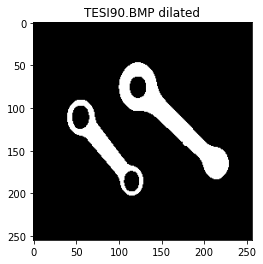

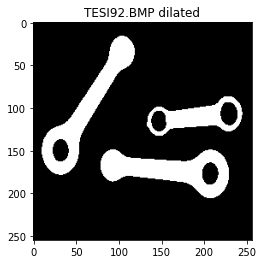

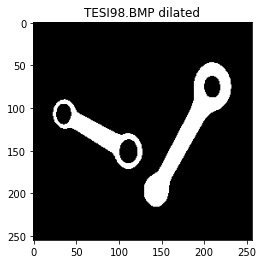

In [76]:
imgs_dict_dil = copy.deepcopy(imgs_dict_bin)
struct1 = np.ones((2,2), np.uint8)

struct2 = np.array([[0,1,0],
                    [1,1,1],
                    [0,1,0]], np.uint8)


for key in task_two3:
    imgs_dict_dil[key] = cv2.morphologyEx(imgs_dict_bin[key], cv2.MORPH_OPEN, struct1) # To remove salt and pepper
    #imgs_dict_dil[key] = cv2.dilate(imgs_dict_dil[key], struct2) # To repair the rods
    
    plt.title(key + ' ' + 'dilated')
    plt.imshow(imgs_dict_dil[key], cmap = 'gray')
    plt.show()    

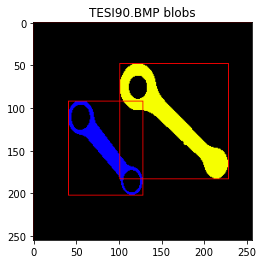

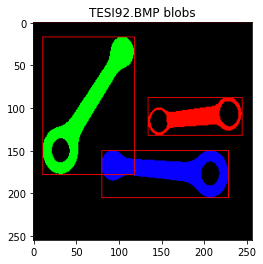

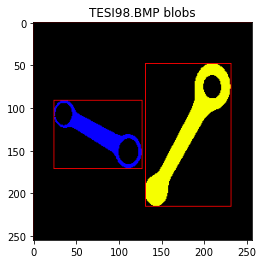

In [68]:
for key in task_two3:
    stat_dict[key] = cv2.connectedComponentsWithStats(np.uint8(imgs_dict_dil[key]), connectivity = 4)
    num_labels, labels, stats, centroids = stat_dict[key]
    
    show_blobs(num_labels, labels, stats)

The image TESI90.BMP has 2 rods:


Rod 1 is of type A, so it has one hole.
The hole is positioned at (122.22901916503906, 75.6434326171875) and it has a diameter of 25.0414.
The rod 1 is positioned at (160.53347778320312, 111.8116226196289) with an angle of 134.8254
The rod 1 has lenght 168.1500 and width 47.8523.
The rod 1 has a width at barycenter of 30.2655.


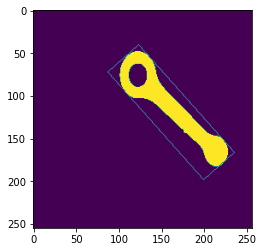

Rod 2 is of type B, so it has two holes.
The first hole is positioned at (114.85517120361328, 185.75726318359375) and it has a diameter of 23.6287.
The second hole is positioned at (55.20188903808594, 110.68346405029297) and it has a diameter of 23.6287.
The rod 2 is positioned at (81.1147232055664, 143.2278289794922) with an angle of 141.8561
The rod 2 has lenght 128.6000 and width 34.0000.
The rod 2 has a width at barycenter of 102.0833.


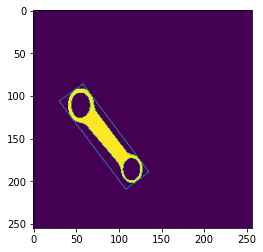

--------------------------------------------------------------------------------------------------------------
The image TESI92.BMP has 3 rods:


Rod 1 is of type A, so it has one hole.
The hole is positioned at (31.861623764038086, 149.65628051757812) and it has a diameter of 24.9650.
The rod 1 is positioned at (56.40633773803711, 109.36480712890625) with an angle of 31.1904
The rod 1 has lenght 178.6185 and width 44.8467.
The rod 1 has a width at barycenter of 91.4440.


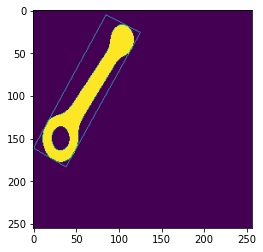

Rod 2 is of type B, so it has two holes.
The first hole is positioned at (146.7181396484375, 115.40403747558594) and it has a diameter of 23.5477.
The second hole is positioned at (228.61666870117188, 106.7748794555664) and it has a diameter of 23.5477.
The rod 2 is positioned at (192.21470642089844, 111.497802734375) with an angle of 83.6695
The rod 2 has lenght 109.7858 and width 38.4250.
The rod 2 has a width at barycenter of 90.3383.


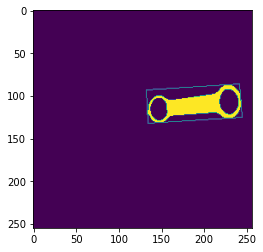

Rod 3 is of type A, so it has one hole.
The hole is positioned at (206.6071014404297, 176.81053161621094) and it has a diameter of 24.9395.
The rod 3 is positioned at (160.81814575195312, 172.52511596679688) with an angle of 95.5726
The rod 3 has lenght 147.0000 and width 54.0000.
The rod 3 has a width at barycenter of 119.8165.


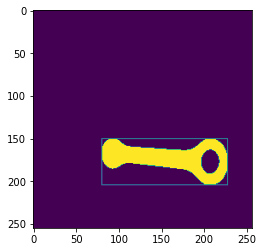

--------------------------------------------------------------------------------------------------------------
The image TESI98.BMP has 2 rods:


Rod 1 is of type A, so it has one hole.
The hole is positioned at (209.0458526611328, 75.29241180419922) and it has a diameter of 24.8115.
The rod 1 is positioned at (189.43630981445312, 111.87749481201172) with an angle of 27.5532
The rod 1 has lenght 181.2324 and width 44.0599.
The rod 1 has a width at barycenter of 97.8366.


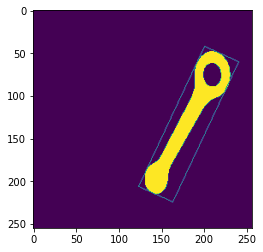

Rod 2 is of type A, so it has one hole.
The hole is positioned at (111.07495880126953, 150.82057189941406) and it has a diameter of 27.2335.
The rod 2 is positioned at (81.47310638427734, 133.3086395263672) with an angle of 120.6841
The rod 2 has lenght 116.5028 and width 37.0318.
The rod 2 has a width at barycenter of 77.2010.


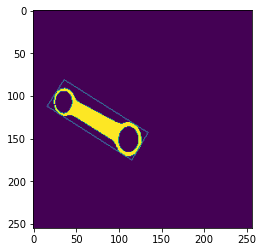

--------------------------------------------------------------------------------------------------------------


In [69]:
for key in task_two3:
    print('The image {} has {} rods:'.format(key, stat_dict[key][0] - 1))
    print('\n')
    
    for i in range(1, stat_dict[key][0]): # Start from 1 since the first is the background
        mask = get_blob(stat_dict[key][1], i) # Get all the blobs of the image at the time
        contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) # Get the contours of the blob
    
        # Check the type of the rod based on the number of contours found on the mask
        if len(contours) == 2:
            print('Rod {} is of type A, so it has one hole.'.format(i))
            
            (x,y), (_,_), angle = cv2.fitEllipse(contours[1])
            area = cv2.contourArea(contours[1])
            equi_diameter = np.sqrt(4*area/np.pi)
            print('The hole is positioned at {} and it has a diameter of {:.4f}.'.format((x,y), equi_diameter))
            
        elif len(contours) == 3:
            print('Rod {} is of type B, so it has two holes.'.format(i))
            
            (x,y), (_,_), angle = cv2.fitEllipse(contours[1])
            area = cv2.contourArea(contours[1])
            equi_diameter = np.sqrt(4*area/np.pi)
            print('The first hole is positioned at {} and it has a diameter of {:.4f}.'.format((x,y), equi_diameter))
            
            (x,y), (_,_), angle = cv2.fitEllipse(contours[2])
            area = cv2.contourArea(contours[1])
            equi_diameter = np.sqrt(4*area/np.pi)
            print('The second hole is positioned at {} and it has a diameter of {:.4f}.'.format((x,y), equi_diameter))
        
        # Orientation calculation
        (x,y), (_,_), angle = cv2.fitEllipse(contours[0])
        print('The rod {:} is positioned at {} with an angle of {:.4f}'. format(i, ((x,y)), angle))
        
        # MER calculation
        MER = cv2.minAreaRect(contours[0])
        # Extraction of the vertexes of the MER
        vertexes = cv2.boxPoints(MER)
        
        # Calculation of width and lenght
        L = max(distances(vertexes))
        W = min(distances(vertexes))
        print('The rod {:} has lenght {:.4f} and width {:.4f}.'. format(i, L, W))
        
        W_b = get_barycenter_width(mask, angle, (x,y), contours)
        print('The rod {:} has a width at barycenter of {:.4f}.'. format(i, W_b))
        
        # MER representation
        pts = np.array(vertexes, np.int32)
        pts = pts.reshape((-1,1,2))
        cv2.polylines(mask, [pts], True, (125,125,125))
    

        plt.imshow(mask)
        plt.show()
        
        
    print('-'*110)   